# Import Libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime

In [2]:
#Set Variables
bar_chart_color = 'tab:blue'

# Import Dataset

In [3]:
dataframe_Jan22 = pd.read_csv('202201-bluebikes-tripdata.csv')
dataframe_Feb22 = pd.read_csv('202202-bluebikes-tripdata.csv')
dataframe_Mar22 = pd.read_csv('202203-bluebikes-tripdata.csv')
dataframe_Apr22 = pd.read_csv('202204-bluebikes-tripdata.csv')
dataframe_May22 = pd.read_csv('202205-bluebikes-tripdata.csv')
dataframe_Jun22 = pd.read_csv('202206-bluebikes-tripdata.csv')
dataframe_Jul22 = pd.read_csv('202207-bluebikes-tripdata.csv')
dataframe_Aug22 = pd.read_csv('202208-bluebikes-tripdata.csv')
dataframe_Sep22 = pd.read_csv('202209-bluebikes-tripdata.csv')
dataframe_Oct22 = pd.read_csv('202210-bluebikes-tripdata.csv')
dataframe_Nov22 = pd.read_csv('202211-bluebikes-tripdata.csv')
dataframe_Dec22 = pd.read_csv('202212-bluebikes-tripdata.csv')
dataframe_stations = pd.read_csv('current_bluebikes_stations.csv')
dataframe_districts = pd.read_csv('district_demographics.csv')

# Data Cleansing

In [4]:
#Union all 2022 data
dataframe_2022 = pd.concat([dataframe_Jan22, dataframe_Feb22, dataframe_Mar22, dataframe_Apr22, dataframe_May22, dataframe_Jun22, dataframe_Jul22, dataframe_Aug22, dataframe_Sep22, dataframe_Oct22, dataframe_Nov22, dataframe_Dec22], ignore_index=True)

In [5]:
#Convert started_at and ended_at to datetimes
dataframe_2022['starttime']= pd.to_datetime(dataframe_2022['starttime'])
dataframe_2022['stoptime']= pd.to_datetime(dataframe_2022['stoptime'])

In [6]:
#Add Month, hour, and day of the week columns
dataframe_2022['month'] = pd.DatetimeIndex(dataframe_2022['starttime']).month
dataframe_2022['hour'] = pd.DatetimeIndex(dataframe_2022['starttime']).hour
dataframe_2022['day_of_week'] = pd.DatetimeIndex(dataframe_2022['starttime']).weekday
dataframe_2022['day_name']= dataframe_2022['starttime'].dt.day_name()

In [7]:
#Add part of day column
dataframe_2022.loc[(dataframe_2022['hour'] > 5) & (dataframe_2022['hour'] <= 12), 'part_of_day'] = 'Morning'
dataframe_2022.loc[(dataframe_2022['hour'] > 12) & (dataframe_2022['hour'] <= 17), 'part_of_day'] = 'Afternoon'
dataframe_2022.loc[(dataframe_2022['hour'] > 17) & (dataframe_2022['hour'] <= 21), 'part_of_day'] = 'Evening'
dataframe_2022.loc[(dataframe_2022['hour'] > 21) | (dataframe_2022['hour'] <= 5), 'part_of_day'] = 'Night' 

In [8]:
dataframe_2022.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'postal code', 'month', 'hour', 'day_of_week', 'day_name',
       'part_of_day'],
      dtype='object')

In [9]:
#Drop not needed columns from ride information dataframe
dataframe_2022 = dataframe_2022.drop(['tripduration', 'start station id', 'start station latitude', 
                     'start station longitude', 'end station id', 'end station longitude',
                    'end station latitude', 'bikeid', 'postal code'], axis = 1)

In [10]:
#Compress All Dataframes
# Code from https://abhisheksingh007226.medium.com/how-to-compress-csv-file-efficiently-in-just-25-lines-of-code-4e974b60b2b8

def compress(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

dataframe_2022 = compress(dataframe_2022)
dataframe_stations = compress(dataframe_stations)
dataframe_districts = compress(dataframe_districts)

Mem. usage decreased to 211.41 Mb (26.2% reduction)
Mem. usage decreased to  0.02 Mb (38.9% reduction)
Mem. usage decreased to  0.00 Mb (66.7% reduction)


In [11]:
dataframe_stations.columns

Index(['Number', 'Name', 'Latitude', 'Longitude', 'District', 'Public',
       'Total docks', 'Deployment Year'],
      dtype='object')

In [12]:
#Drop not needed columns from station information dataframe
dataframe_stations = dataframe_stations.drop(['Public', 'Total docks', 'Deployment Year'], axis = 1)

In [13]:
#Merge station info to start station 
df = pd.merge(dataframe_2022, dataframe_stations, left_on='start station name', right_on='Name')

In [14]:
#Merge district demographic info by start station district
df = pd.merge(df, dataframe_districts, left_on='District', right_on='City')

# Descriptive Statistics/ Visualization of Data

# Ride Analysis

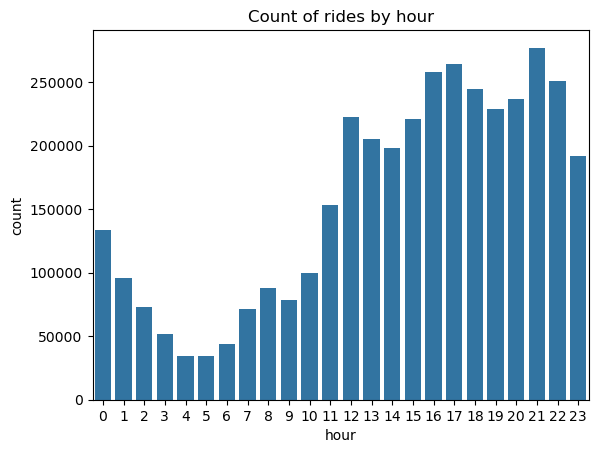

In [15]:
sns.countplot(data = dataframe_2022, x = 'hour', color = bar_chart_color).set(title='Count of rides by hour')
plt.show()

The plot above shows ridership increases throughout the day and is at it's highest between 15 and 22. This could be evening commute and/or going for drinks in the evening.

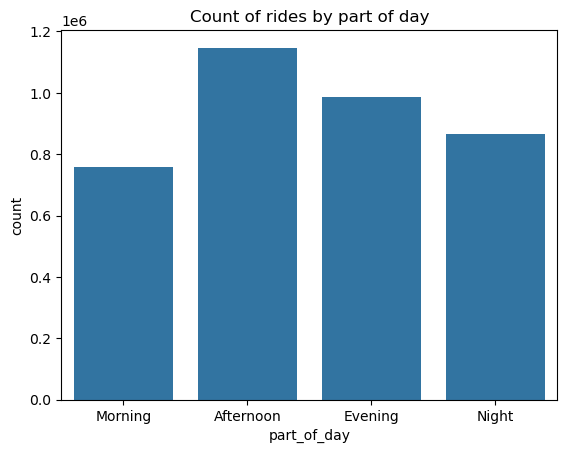

In [16]:
part_order = ['Morning', 'Afternoon', 'Evening', 'Night']
sns.countplot(data= dataframe_2022, x = 'part_of_day', order = part_order, color = bar_chart_color).set(title='Count of rides by part of day')
plt.show()

Most rides occur in the afternoon, followed by evening, night time, and then last Mornings. 

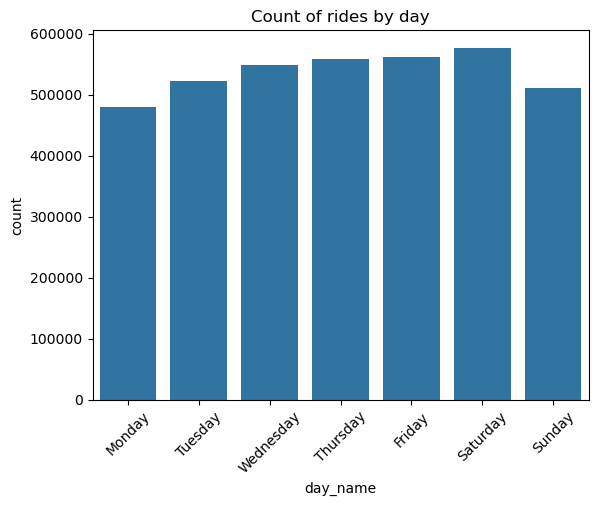

In [17]:
category_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data= dataframe_2022, x = 'day_name', order = category_order, color = bar_chart_color).set(title='Count of rides by day')
plt.xticks(rotation=45)
plt.show()

Looking at days of the week ridership is lowest on Sunday and Monday. Saturday is the most popular day.

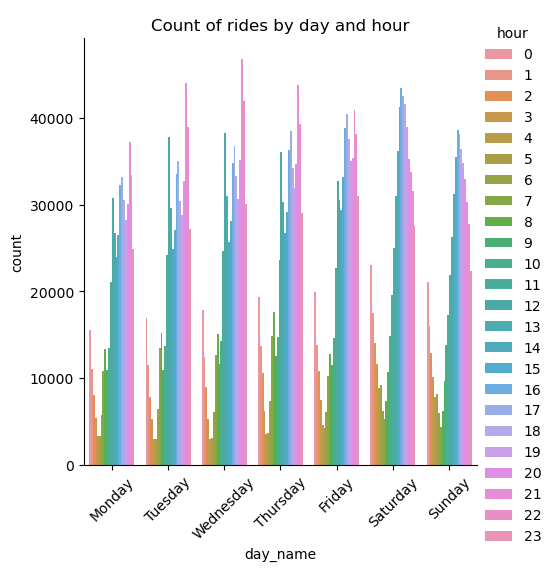

In [18]:
sns.catplot(data= dataframe_2022, x = 'day_name', kind= 'count', hue ='hour', order = category_order).set(title='Count of rides by day and hour')
plt.xticks(rotation=45)
plt.show()

Breaking time of rides down further the above graph shows ridership rise around 11 and then a large spike around 20 during the weekdays. On the weekends there is a small increase around midnight. The majority of rides happen between 11 and 23 on the weekends. 

# District Analysis

In [19]:
count_of_stations = df.groupby(['District']).agg({'start station name': pd.Series.nunique}).sort_values(by = ['start station name'], ascending = False).reset_index()
count_of_stations.rename(columns= {'start station name': 'count_of_stations'})

,District,count_of_stations
0,Boston,249
1,Cambridge,76
2,Somerville,32
3,Brookline,14
4,Everett,14
5,Newton,14
6,Salem,14
7,Arlington,6
8,Chelsea,6
9,Watertown,6


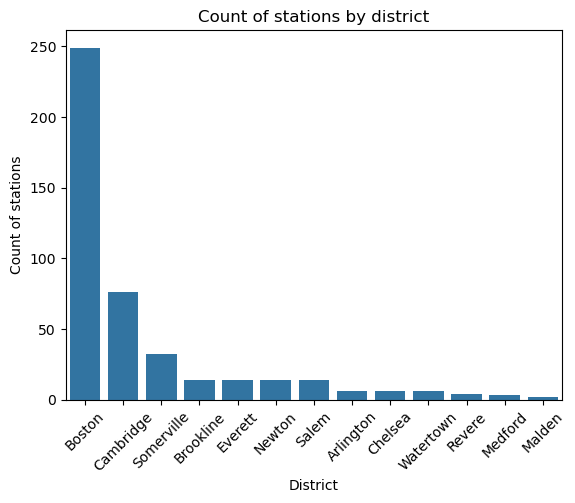

In [20]:
#Count of start stations by District
ax = sns.barplot(data= count_of_stations, x = 'District', y = 'start station name', color = bar_chart_color)
ax.set(xlabel ="District", ylabel = "Count of stations", title ='Count of stations by district')
plt.xticks(rotation=45)
plt.show()

Boston has the most stations, followed by Cambridge and Somerville. 

In [21]:
#Create dataframe for count of rides by district
district_count_of_rides = df.groupby(['District'])['starttime'].count().sort_values(ascending = False).reset_index()
district_count_of_rides.rename(columns= {'starttime': 'count_of_rides'})


,District,count_of_rides
0,Boston,2047105
1,Cambridge,1282058
2,Somerville,190261
3,Brookline,104645
4,Everett,14259
5,Watertown,13615
6,Arlington,12757
7,Salem,10262
8,Newton,10114
9,Revere,3437


In [22]:
#Create dataframe with relevant information for count of rides per 1000 persons
df1 = pd.merge(district_count_of_rides, count_of_stations, on = 'District')

In [23]:
#Create dataframe with relevant information for count of rides per district population
pop = dataframe_districts[['City', 'Population, Census, April 1, 2020']]

In [24]:
df1 = pd.merge(df1, pop, left_on = 'District', right_on = 'City')


In [25]:
df1.head()

,District,starttime,start station name,City,"Population, Census, April 1, 2020"
0,Boston,2047105,249,Boston,675647
1,Cambridge,1282058,76,Cambridge,118403
2,Somerville,190261,32,Somerville,81045
3,Brookline,104645,14,Brookline,63191
4,Everett,14259,14,Everett,49075


In [26]:
#Calculate rides per 1000 people
df1['rides_per_1000_people'] = df1['starttime']/df1['Population, Census, April 1, 2020'] * 1000

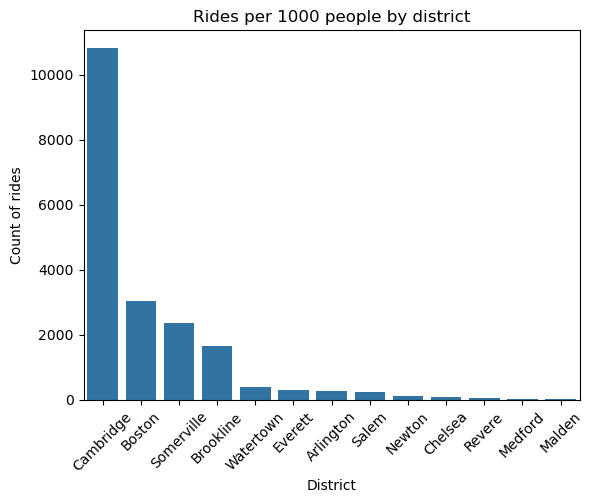

In [27]:
#Rides per 1000 people by district
sns.barplot(data= df1, x = 'District', y = 'rides_per_1000_people', color = bar_chart_color, order=df1.sort_values('rides_per_1000_people', ascending=False).District).set(title='Rides per 1000 people by district')
#ax.set(xlabel ="District", ylabel = "Count of rides", title ='Rides per 1000 people by district')
plt.xlabel('District')
plt.ylabel('Count of rides')
plt.xticks(rotation=45)
plt.show()

When visualizing rides per 1000 persons, Cambridge again out performs Boston. Somerville and Brookline also perform well. 

# Issue to Explore

Of the abutting districts to current districts with BlueBike stations, what district should test stations be located in based on current district demographic data to maximize ride count per 1000 people? 

In [15]:
#Group by start station name and district, aggregate count of riders
agg = df.groupby(['start station name', 'District'])['starttime'].count().sort_values(ascending=False).reset_index()
agg.shape

(440, 3)

In [16]:
#Merge aggregate dataframe with district demographics dataframe
result = pd.merge(agg, dataframe_districts, left_on='District', right_on = 'City')


In [17]:
#Rename Columns
result = result.rename(columns = {'starttime': 'count_of_rides', 
                                  "Bachelor's degree or higher, percent of persons age 25 years+, 2017-2021" : 
                                  'Bachelors degree or higher, percent of persons age 25 years+, 2017-2021'})

In [18]:
result.columns

Index(['start station name', 'District', 'count_of_rides', 'City',
       'Population, Census, April 1, 2020', 'Persons under 5 years, percent',
       'Persons under 18 years, percent', 'Persons 65 years and over, percent',
       'Female persons, percent',
       'White alone, not Hispanic or Latino, percent', 'Veterans, 2017-2021',
       'Foreign born persons, percent, 2017-2021',
       'Owner-occupied housing unit rate, 2017-2021',
       'Median value of owner-occupied housing units, 2017-2021',
       'Median selected monthly owner costs -with a mortgage, 2017-2021',
       'Median selected monthly owner costs -without a mortgage, 2017-2021',
       'Median gross rent, 2017-2021', 'Households, 2017-2021',
       'Persons per household, 2017-2021',
       'Living in same house 1 year ago, percent of persons age 1 year+, 2017-2021',
       'Language other than English spoken at home, percent of persons age 5 years+, 2017-2021',
       'Households with a computer, percent, 2017-20

In [19]:
#Add calculated column of riders per census population
result['rides_per_1000_people'] = result['count_of_rides']/result['Population, Census, April 1, 2020'] * 1000

In [20]:
#Drop columns with blank rows
result=result.dropna(axis=1)

In [21]:
#Drop count of rides
result=result.drop(['count_of_rides'], axis=1)

In [22]:
correlated_dataframe = result.corr()

In [23]:
#Create series with all variables with greater than abs(0.3) correlation with rides per 1000 people
correlated_variables = correlated_dataframe['rides_per_1000_people'][abs(correlated_dataframe['rides_per_1000_people'])>= 0.4]
correlated_variables = correlated_variables.loc[~correlated_variables.index.isin(['rides_per_1000_people'])]
correlated_variables

Population, Census, April 1, 2020                                             -0.447743
Veterans, 2017-2021                                                           -0.467860
Median value of owner-occupied housing units, 2017-2021                        0.515235
Median gross rent, 2017-2021                                                   0.623568
Households, 2017-2021                                                         -0.445664
Living in same house 1 year ago, percent of persons age 1 year+, 2017-2021    -0.520291
Households with a computer, percent, 2017-2021                                 0.493068
High school graduate or higher, percent of persons age 25 years+, 2017-2021    0.439687
Bachelors degree or higher, percent of persons age 25 years+, 2017-2021        0.530067
With a disability, under age 65 years, percent, 2017-2021                     -0.572263
Mean travel time to work (minutes), workers age 16 years+, 2017-2021          -0.452827
Per capita income in past 12 mon

In [24]:
#Use correlated variabels to filter columns
correlated_dataframe2 = result[correlated_variables.index].corr()

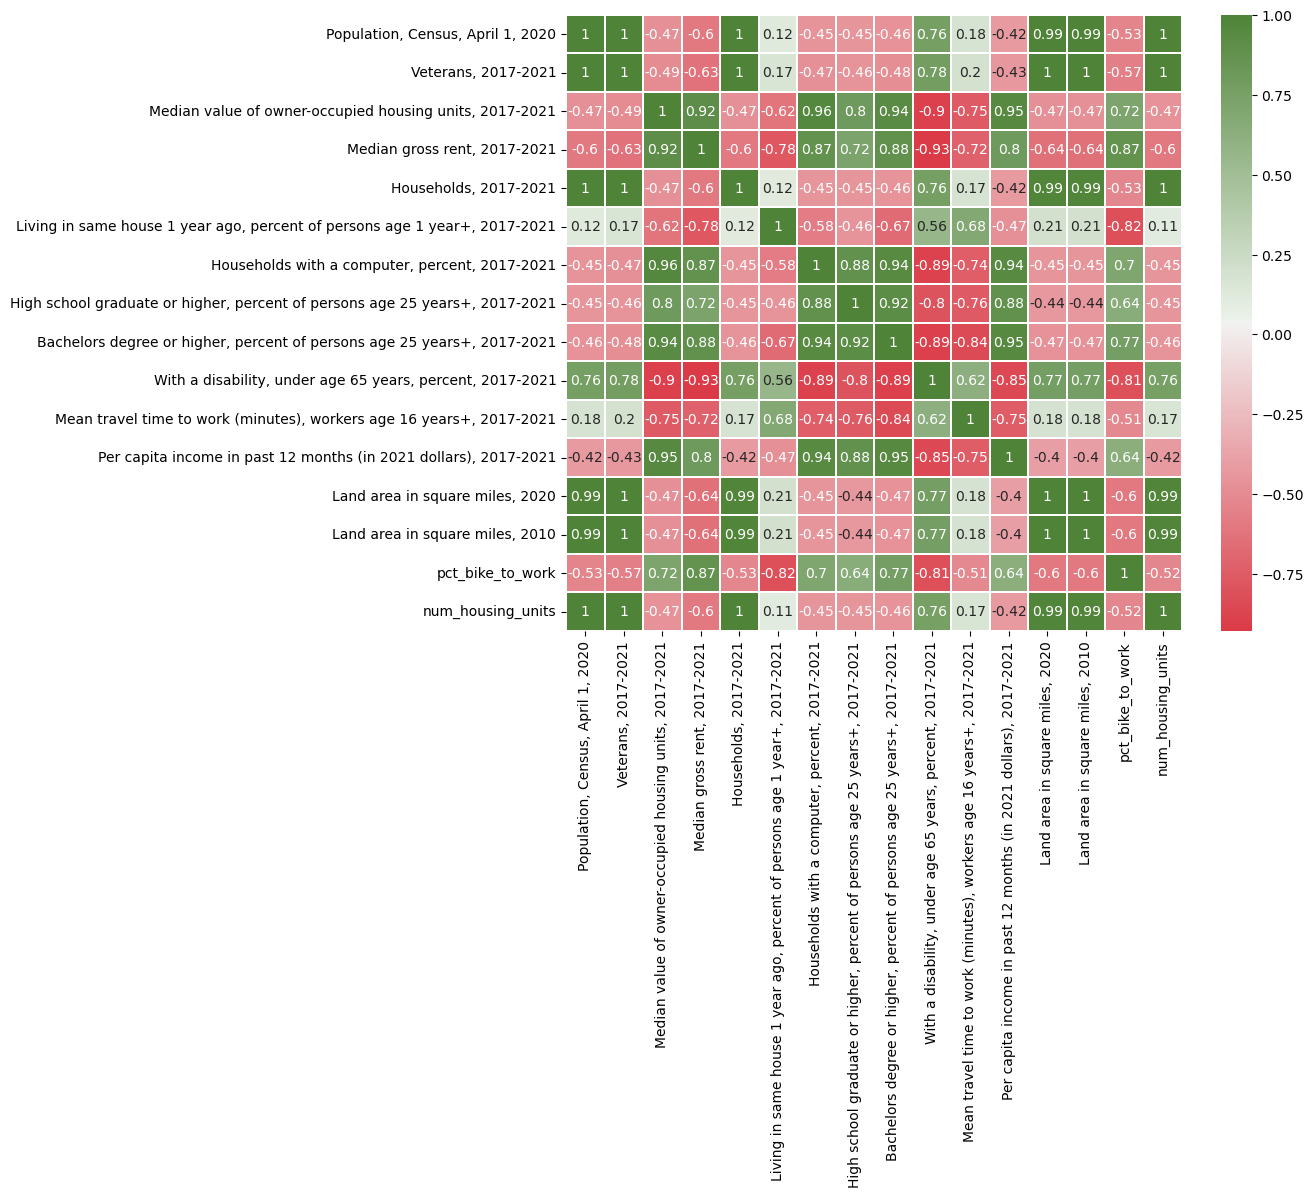

In [25]:
#Run correlation matrix of variables with correlation to rides_per_1000_people >= 0.3 to 
#assess correlation amoung independent variables
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlated_dataframe2, cmap=sns.diverging_palette(10, 120, as_cmap=True), linewidths=.1, annot=True, square=True, ax=ax)
plt.title('', size=15)
plt.show()

Some of the variables that correlate with the dependent variable (rides per 1000 people) appear to be highly correlated with each other, meaning they are not truely independent. 

Ordered by highest correlation and dropped variables with > 0.75 correlation

In [26]:
#Drop variables that are highly correlated with each other
result = result.drop(['Median value of owner-occupied housing units, 2017-2021', 
                      'Living in same house 1 year ago, percent of persons age 1 year+, 2017-2021',
                      'Households with a computer, percent, 2017-2021', 'Bachelors degree or higher, percent of persons age 25 years+, 2017-2021',
                      'With a disability, under age 65 years, percent, 2017-2021', 'Per capita income in past 12 months (in 2021 dollars), 2017-2021',
                      'pct_bike_to_work', 'Land area in square miles, 2010','Population, Census, April 1, 2020',
                      'Households, 2017-2021', 'num_housing_units', 'Veterans, 2017-2021',
                      'High school graduate or higher, percent of persons age 25 years+, 2017-2021'], axis=1)

In [27]:
#Run correlation on filtered dataframe
correlated_dataframe = result.corr()

In [28]:
#Select remaining variables that are correlated with rides per 1000 people
correlated_variables = correlated_dataframe['rides_per_1000_people'][abs(correlated_dataframe['rides_per_1000_people'])>= 0.4]
correlated_variables = correlated_variables.loc[~correlated_variables.index.isin(['rides_per_1000_people', 'count_of_rides'])]
correlated_variables

Median gross rent, 2017-2021                                            0.623568
Mean travel time to work (minutes), workers age 16 years+, 2017-2021   -0.452827
Land area in square miles, 2020                                        -0.483236
Name: rides_per_1000_people, dtype: float64

In [29]:
#Use correlated variables to create new correlation matrix to assess for interacting independent variables
correlated_dataframe2 = result[correlated_variables.index].corr()

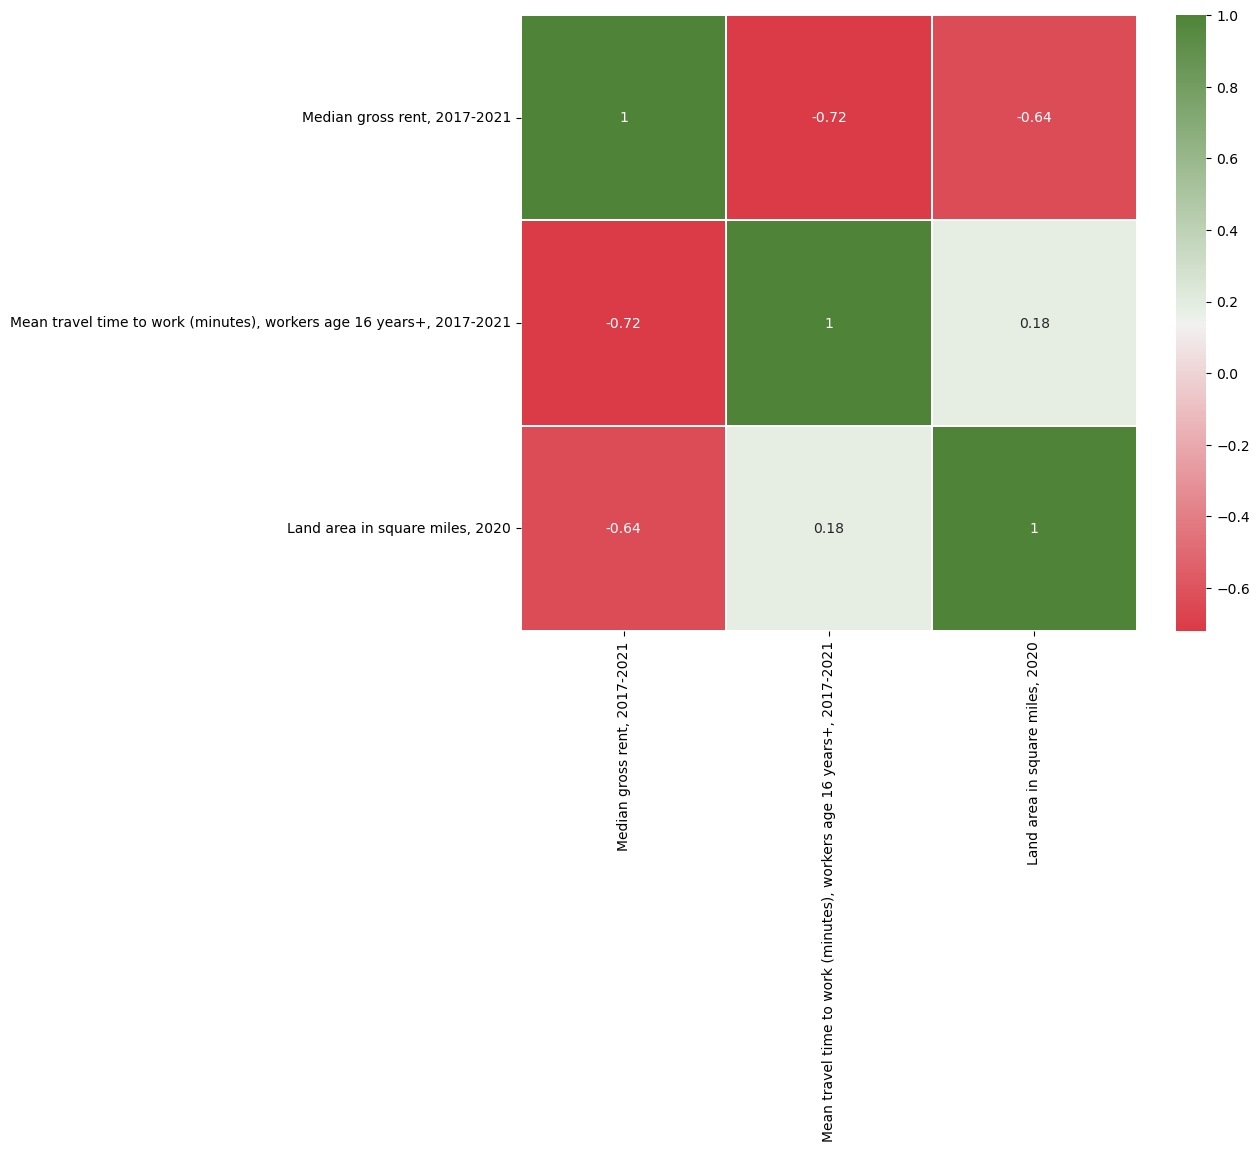

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlated_dataframe2, cmap=sns.diverging_palette(10, 120, as_cmap=True), linewidths=.1, annot=True, square=True, ax=ax)
plt.title('', size=15)
plt.show()

In [53]:
# fig, axes = plt.subplots(nrows=3, figsize= (10,15))

# dataframe_districts.plot(ax=axes[0], kind = 'bar', x="City", y = 'Median gross rent, 2017-2021', color = bar_chart_color)
# axes[0].set_title('Variables highly correlated with rides per 1000 people')
# axes[0].set_ylabel('Dollars')

# dataframe_districts.plot(ax=axes[1], kind = 'bar', x="City", y = 'Mean travel time to work (minutes), workers age 16 years+, 2017-2021')
# axes[1].set_ylabel('Minutes')

# dataframe_districts.plot(ax=axes[2], kind = 'bar', x="City", y = 'Land area in square miles, 2020')
# axes[2].set_ylabel('Square miles')

# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.4,
#                     hspace=0.4)
# plt.show()

In [31]:
list(correlated_variables.index)

['Median gross rent, 2017-2021',
 'Mean travel time to work (minutes), workers age 16 years+, 2017-2021',
 'Land area in square miles, 2020']

In [32]:
#Run regression analysis all variables with correlation >=abd(0.3) to RIDES PER 1000 PEOPLE that 
#do not interact with each other
dependent_variable = result['rides_per_1000_people']
independent_variable = result[list(correlated_variables.index)]
independent_variable = sm.add_constant(independent_variable)
regression_model = sm.OLS(dependent_variable.astype(float), independent_variable.astype(float)).fit()
print(regression_model.summary())

                              OLS Regression Results                             
Dep. Variable:     rides_per_1000_people   R-squared:                       0.406
Model:                               OLS   Adj. R-squared:                  0.402
Method:                    Least Squares   F-statistic:                     99.43
Date:                   Mon, 01 May 2023   Prob (F-statistic):           4.77e-49
Time:                           14:45:17   Log-Likelihood:                -2417.1
No. Observations:                    440   AIC:                             4842.
Df Residuals:                        436   BIC:                             4859.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

In [96]:
df_expansion = pd.read_csv('districts_for_expansion.csv')

There are 15 districts abutting the current districts with BlueBike stations. The statistically significant demographic variables were plotted against the 15 districts against the average for these variables across these 15 districts. 

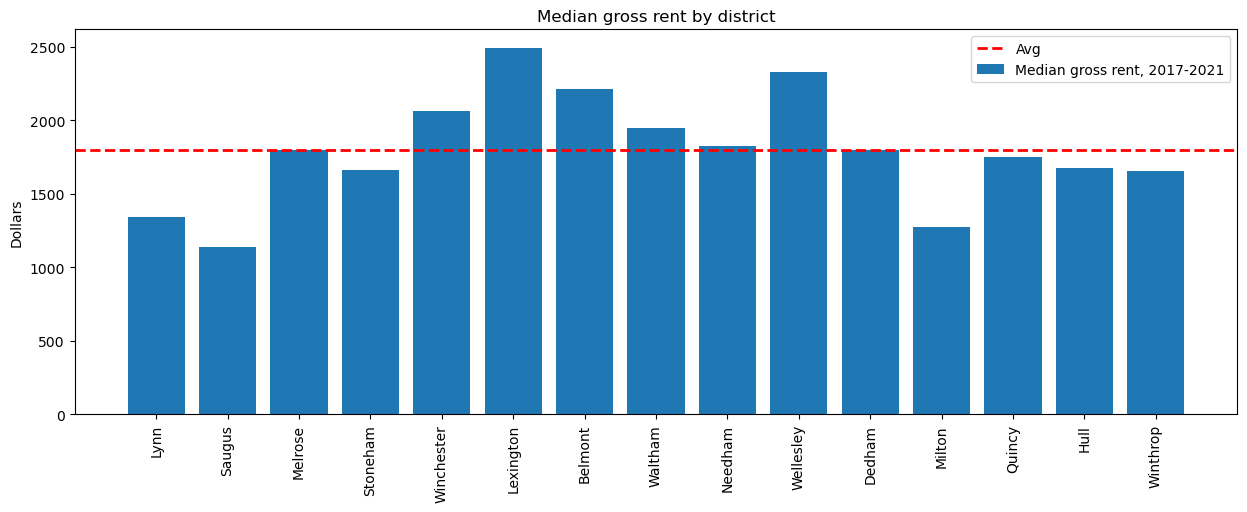

In [94]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.bar(df_expansion['City'], df_expansion['Median gross rent, 2017-2021'], label='Median gross rent, 2017-2021')
plt.axhline(y=np.nanmean(df_expansion['Median gross rent, 2017-2021']), color='red', linestyle='--', linewidth=2, label='Avg')
ax.set_ylabel('Dollars')
ax.set_title('Median gross rent by district')
plt.xticks(rotation=90)
ax.legend()
plt.show()

Median gross rent is positively correlated with increased ridership. There are 6 districts with above the average median gross rent. 
    Winchester, Lexington, Belmont, Waltham, Needham, Wellesley

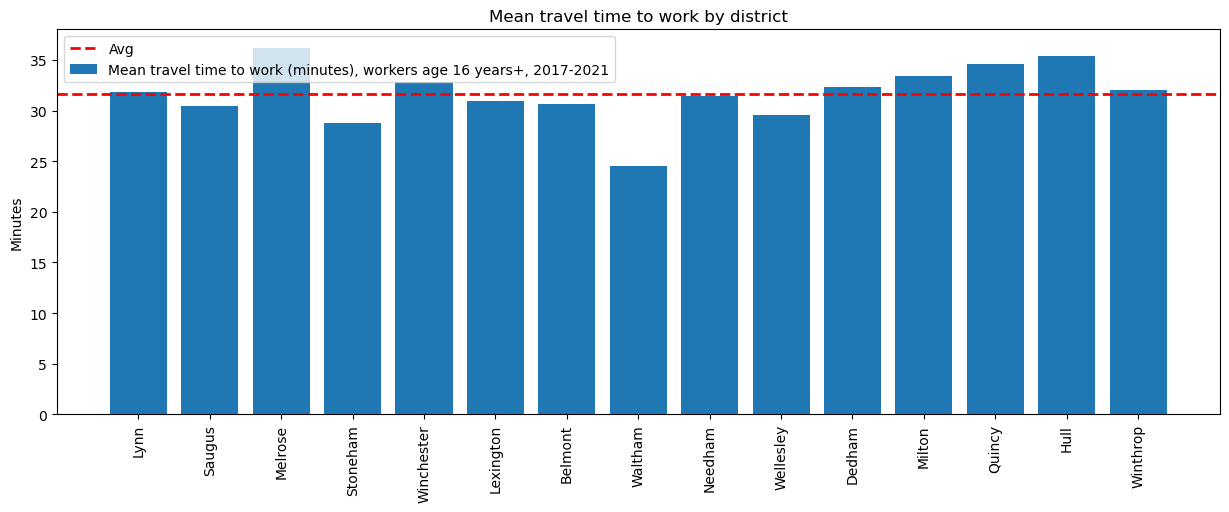

In [91]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.bar(df_expansion['City'], df_expansion['Mean travel time to work (minutes), workers age 16 years+, 2017-2021'], label='Mean travel time to work (minutes), workers age 16 years+, 2017-2021')
plt.axhline(y=np.nanmean(df_expansion['Mean travel time to work (minutes), workers age 16 years+, 2017-2021']), color='red', linestyle='--', linewidth=2, label='Avg')
ax.set_ylabel('Minutes')
ax.set_title('Mean travel time to work by district')
plt.xticks(rotation=90)
ax.legend()
plt.show()

Mean travel to work time is negatively correlated with ridership. There are 5 variables that met the first criteria that also are below the average travel to work time.
    Lexington, Belmont, Waltham, Needham, Wellesley

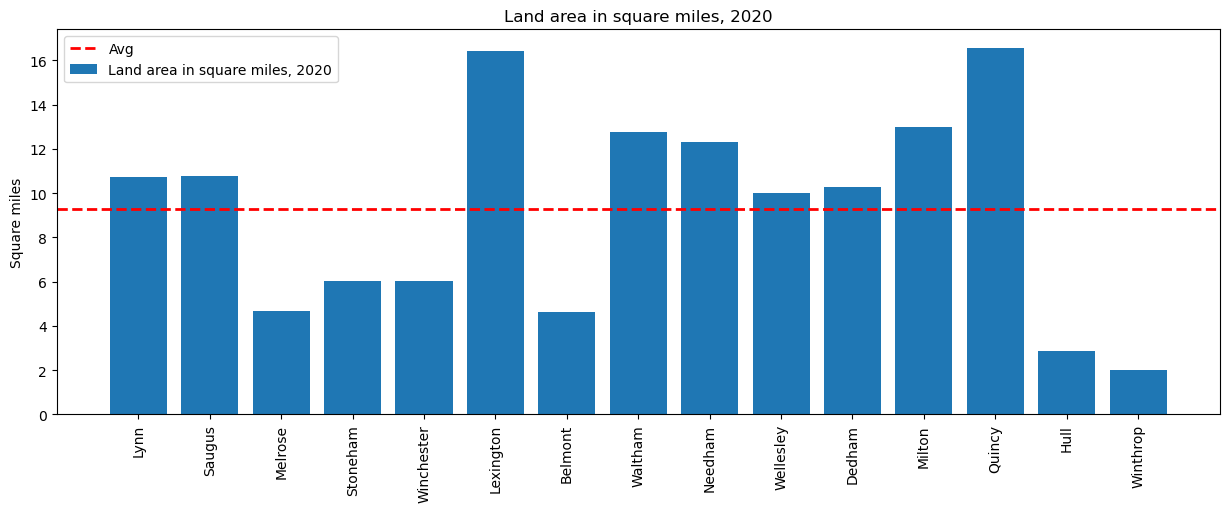

In [92]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.bar(df_expansion['City'], df_expansion['Land area in square miles, 2020'], label='Land area in square miles, 2020')
plt.axhline(y=np.nanmean(df_expansion['Land area in square miles, 2020']), color='red', linestyle='--', linewidth=2, label='Avg')
ax.set_ylabel('Square miles')
ax.set_title('Land area in square miles, 2020')
plt.xticks(rotation=90)
ax.legend()
plt.show()

Land area in square miles is negatively correlated with ridership. Of the 5 districts that meet the first 2 criteria, there is only one district with lower than average land area, Belmont. 

In [110]:
df_expansion.head()

,City,"Population Estimates, July 1, 2022, (V2022)","Population Estimates, July 1, 2021, (V2021)","Population estimates base, April 1, 2020, (V2022)","Population estimates base, April 1, 2020, (V2021)","Population, percent change - April 1, 2020 (estimates base) to July 1, 2022, (V2022)","Population, percent change - April 1, 2020 (estimates base) to July 1, 2021, (V2021)","Population, Census, April 1, 2020","Population, Census, April 1, 2010","Persons under 5 years, percent",...,"Nonveteran-owned employer firms, Reference year 2017","Population per square mile, 2020","Population per square mile, 2010","Land area in square miles, 2020","Land area in square miles, 2010",Avg_pop_age,pct_bike_to_work,num_housing_units,renter_occupied,med_value_housing
0,Lynn,NaN,"100,843",NaN,"101,238",NaN,-0.40%,"101,253","90,329",6.50%,...,"1,165","9,428.50","8,409.50",10.74,10.74,37.8,0.00,39222.0,0.47,423800.0
1,Saugus,NaN,"28,676",NaN,"28,612",NaN,0.20%,"28,619","26,628",4.10%,...,480,"2,656.10","2,467.00",10.78,10.79,43.6,0.00,11254.0,0.22,468300.0
2,Melrose,NaN,"29,312",NaN,"29,860",NaN,-1.80%,"29,817","26,983",5.80%,...,504,"6,367.10","5,767.20",4.68,4.68,42.1,0.01,12276.0,0.33,638800.0
3,Stoneham,NaN,"22,877",NaN,"23,284",NaN,-1.70%,"23,244","21,437",5.80%,...,473,"3,864.30","3,561.50",6.02,6.02,42.8,0.00,10004.0,0.32,549600.0
4,Winchester,NaN,"22,662",NaN,"22,995",NaN,-1.40%,"22,970","21,374",5.70%,...,407,"3,808.00","3,545.60",6.03,6.03,42.4,0.01,8299.0,0.18,1001300.0


In [135]:
#Selection = district['Gross Rent']>= mean['gross rent'] 
#    && district['mean travel timte to work'] <= mean['travel time to work']
#    && district['land area'] <= mean['land area']

expansion = df_expansion[(df_expansion['Median gross rent, 2017-2021'] >= df_expansion['Median gross rent, 2017-2021'].mean())] 
                             

print(expansion['City'])



4    Winchester
5     Lexington
6       Belmont
7       Waltham
8       Needham
9     Wellesley
Name: City, dtype: object


In [136]:
expansion = expansion[(expansion['Mean travel time to work (minutes), workers age 16 years+, 2017-2021'] <= df_expansion['Mean travel time to work (minutes), workers age 16 years+, 2017-2021'].mean())] 

print(expansion['City'])

5    Lexington
6      Belmont
7      Waltham
8      Needham
9    Wellesley
Name: City, dtype: object


In [138]:
expansion = expansion[(expansion['Land area in square miles, 2020'] <= df_expansion['Land area in square miles, 2020'].mean())] 

print(expansion['City'])

6    Belmont
Name: City, dtype: object


In [73]:
# fig, axes = plt.subplots(nrows=3, figsize= (10,15))

# df_expansion.plot(ax=axes[0], kind = 'bar', x="City", y = 'Median gross rent, 2017-2021', color = bar_chart_color)
# axes[0].set_title('Variables highly correlated with rides per 1000 people')
# axes[0].set_ylabel('Dollars')

# df_expansion.plot(ax=axes[1], kind = 'bar', x="City", y = 'Mean travel time to work (minutes), workers age 16 years+, 2017-2021')
# axes[1].set_ylabel('Minutes')

# df_expansion.plot(ax=axes[2], kind = 'bar', x="City", y = 'Land area in square miles, 2020')
# axes[2].set_ylabel('Square miles')
#
# plt.subplots_adjust(left=0.1,
#                      bottom=0.1,
#                      right=0.9,
#                      top=0.9,
#                      wspace=0.4,
#                      hspace=0.4)

# plt.show()

# Insights

With an R Squared of 0.406, the model is a low to moderate fit for using the intependent variables to explain the dependent variable. There were 16 variables that correlated with rides per 1000 people > abs(0.4). Of those variables we saw high correlation between these independent variables meaning they were not truely independent. Narrowing the variables down by selecting the highest correlated variables that had less than 0.75 correlation with each other. This left 3 variables remaining. When the linear regression model was run, all 3 variables were statistically signficicant. 'Median gross rent, 2017-2021', 'Mean travel time to work (minutes), workers age 16 years+, 2017-2021', 'Land area in square miles, 2020'. Mediant gross rent was positively associated with rides per 1000 people, mean travel time to work and land area in square miles were negatively associated with rides per 1000 people.


These 3 variables were taken into consideration when looking to expand to an abutting district. There are 15 districts abutting the current districts with BlueBike stations. Of these 15, 6 had above than the average (of the 15 abutting districts) median gross rent, 7 were below the average mean travel time to work, and 6 were below the average land area. 

1 District met all 3 conditions, Belmont. Indicating Belmont may have increased ridership if we expand to this district. We should look into test sites for possible expansion of our station locations. 

Other variables that may be helpful for directing expansion would be number of colleges, and if the current infrastructure is bike friendly.